In [5]:
# Course : CS 513 - Knowledge Discovery and Data Mining
# Group Members: Branden Bulatao, Joseph Faustino, Natalie Fortes, Isabel Sutedjo
# Id : 20006007
# Purpose : Music Happiness Predictor - Predicts the happiness of music tracks based on various features.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import dataset
df = pd.read_csv('./dataset.csv')

df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True) # drop unnamed column
df.dropna(inplace=True) # drop rows with null values

df['valence'] = df['valence'].astype('category')
df['valence'] = df['valence'].map(lambda x: 0 if x < 0.5 else 1) # sets valence to 0 if sad, 1 if happy

# Convert 'explicit' boolean to integer (0/1)
df['explicit'] = df['explicit'].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['key', 'time_signature', 'track_genre'], drop_first=True)

scaler = StandardScaler()
X = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'valence'], axis=1)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = df['valence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,1.782624,0.024557,-0.305769,0.629239,-0.717147,0.300825,-1.326297,0.551843,-0.850193,-0.504111,...,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073
1,0.975625,-0.730889,-0.305769,-0.845908,-1.889974,-1.784739,0.753979,-0.078995,1.831744,-0.504097,...,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073
2,1.065291,-0.160353,-0.305769,-0.742187,-1.122667,-0.293289,0.753979,-0.273827,-0.315489,-0.504115,...,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073
3,1.692957,-0.243236,-0.305769,-1.733301,-2.312987,-2.039246,0.753979,-0.457309,1.774605,-0.503886,...,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073
4,2.186123,-0.271942,-0.305769,0.295026,-0.788709,-0.282751,0.753979,-0.303146,0.463409,-0.504115,...,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113994,-0.548707,1.462948,-0.305769,-2.274956,-1.615652,-1.617321,0.753979,-0.401507,0.977663,2.493742,...,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,10.630099
113995,-0.503873,1.462957,-0.305769,-2.263432,-2.084782,-2.000075,-1.326297,-0.421369,2.042258,2.648803,...,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,10.630099
113996,-0.503873,0.404815,-0.305769,0.358411,-1.241937,-0.524135,-1.326297,-0.403399,1.660327,-0.504115,...,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,10.630099
113997,0.347959,0.520635,-0.305769,0.116395,-0.538241,-0.522942,0.753979,-0.519731,0.198764,-0.504115,...,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,-0.094073,10.630099


In [ ]:
from sklearn.neural_network import MLPClassifier

# Model 7: ANN
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=10000, random_state=42)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: \n{accuracy * 100:.2f}%\n")

report = classification_report(y_test, y_pred)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(report)

print("Confusion Matrix:")
print(cm)

Accuracy: 
77.90%

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     12336
           1       0.77      0.74      0.75     10464

    accuracy                           0.78     22800
   macro avg       0.78      0.78      0.78     22800
weighted avg       0.78      0.78      0.78     22800

Confusion Matrix:
[[10033  2303]
 [ 2736  7728]]


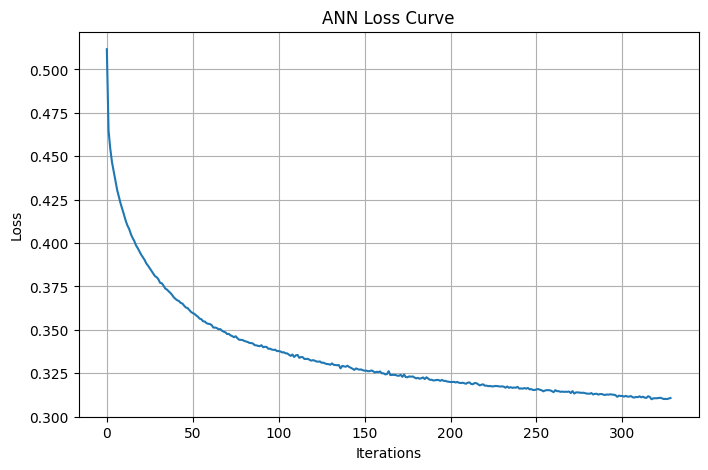

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(mlp.loss_curve_)
plt.title("ANN Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

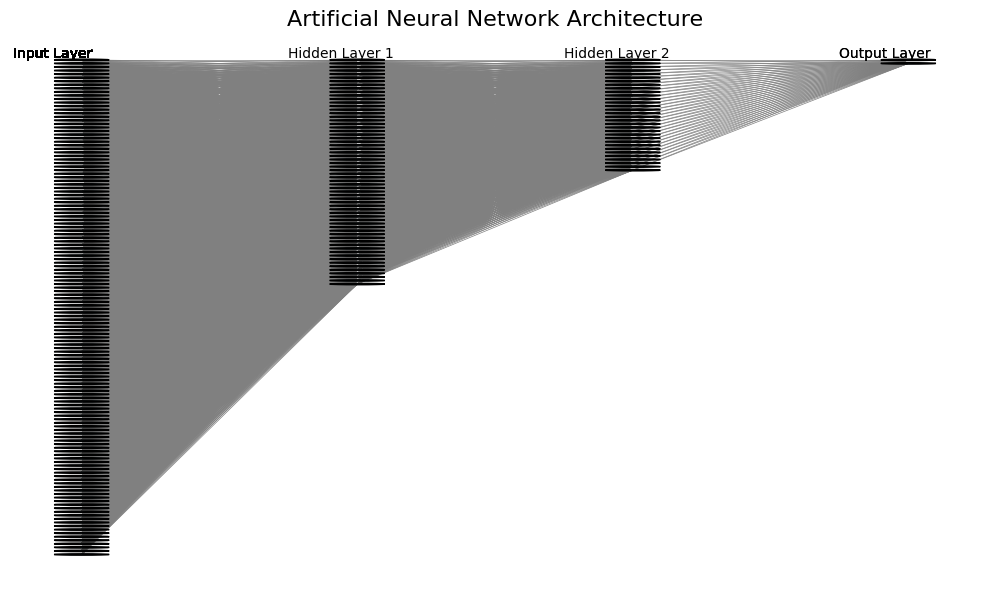

In [3]:
import matplotlib.pyplot as plt

def draw_ann(layer_sizes, node_radius=0.2):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    ax.set_title("Artificial Neural Network Architecture", fontsize=16)

    n_layers = len(layer_sizes)
    v_spacing = 1
    h_spacing = 2
    max_nodes = max(layer_sizes)

    positions = {}

    for i, n_nodes in enumerate(layer_sizes):
        layer_x = i * h_spacing
        top_y = (max_nodes - 1) * v_spacing / 2
        positions[i] = []
        for j in range(n_nodes):
            y = top_y - j * v_spacing
            circle = plt.Circle((layer_x, y), radius=node_radius, fill=True, color='skyblue', ec='black', zorder=3)
            ax.add_patch(circle)
            positions[i].append((layer_x, y))

            # Add labels to layers
            if i == 0:
                ax.text(layer_x - 0.5, top_y + 0.5, "Input Layer", fontsize=10)
            elif i == n_layers - 1:
                ax.text(layer_x - 0.5, top_y + 0.5, "Output Layer", fontsize=10)
            elif j == 0:
                ax.text(layer_x - 0.5, top_y + 0.5, f"Hidden Layer {i}", fontsize=10)

    # Draw connections
    for i in range(n_layers - 1):
        for (x1, y1) in positions[i]:
            for (x2, y2) in positions[i + 1]:
                ax.plot([x1, x2], [y1, y2], 'gray', linewidth=0.5, zorder=1)

    plt.tight_layout()
    plt.show()

input_size = X_train.shape[1]
output_size = len(set(y_train))  # number of classes

draw_ann([input_size, 64, 32, output_size])

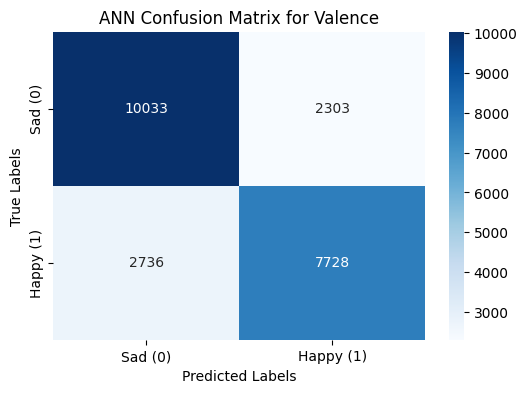

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the heatmap
plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", ax=ax)

# Labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("ANN Confusion Matrix for Valence")
ax.xaxis.set_ticklabels(["Sad (0)", "Happy (1)"])
ax.yaxis.set_ticklabels(["Sad (0)", "Happy (1)"])

plt.show()